Install requirements

Import libraries

In [ ]:
!pip install tensorflow tensorflow-datasets librosa

Only grab the dataset where instument == keyboard

In [ ]:
# =================== Augmentation Function Library ==================
def noise_injection(audio, noise_factor = 0.001):
  '''Inject random/white noise into the audio'''
  noise = np.random.randn(len(audio))
  return audio + noise_factor * noise

def change_speed(audio, speed_factor = 2):
  '''
  Changes the speed of playback by scaling time
  speed_factor > 1      => speeds up playback
  0 < speed_factor < 1  => slows down playback
  '''
  return librosa.effects.time_stretch(audio, rate=speed_factor)

def change_speed_and_fit(audio, stretch_factor = 0.5):
  '''Changes speed similar to change_speed and fits into the same length as the input audio'''
  input_length = len(audio)
  stretched_audio = librosa.effects.time_stretch(audio.astype('float'), rate=stretch_factor)
  if len(stretched_audio) > input_length:
    return stretched_audio[:input_length]
  else:
    return np.pad(stretched_audio, (0, max(0, input_length - len(stretched_audio))), "constant")

def shift_pitch(audio, steps = 10, sr=16000):
  '''Shifts the pitch up by the specified amount of steps'''
  return librosa.effects.pitch_shift(audio, sr=sr, n_steps=steps)

def shift_time(audio, shift_factor = 0.5, random = False):
  '''Shifts the audio in time by a given factor, keeping the same length of the intial audio'''
  if random:
    shift_factor = shift_factor * 2 * (np.random.uniform() - 0.5)

  start = int(len(audio) * shift_factor)
  if (start > 0):
      return np.pad(audio,(start,0),mode='constant')[0:len(audio)]
  else:
      return np.pad(audio,(0,-start),mode='constant')[0:len(audio)]

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import librosa
import numpy as np

# Constants
KEYBOARD_FAMILY_LABEL = 4 # According to NSynth dataset family label
SAMPLE_RATE = 16000
TRIM_LENGTH = 3 * SAMPLE_RATE  # Trim to the first 3 seconds

# Define the processing function
def process_data(example):
    audio = example['audio']
    instrument_family = example['instrument']['family']
    pitch = example['pitch']

    # Filter keyboard samples
    is_keyboard = tf.equal(instrument_family, KEYBOARD_FAMILY_LABEL)
    # Only process the samples where is_keyboard is True
    def process_keyboard_sample(audio, pitch):
        # Trim the audio
        audio = audio[:TRIM_LENGTH]

        # Convert audio to CQT (Constant-Q Transform) using librosa
        # Set fmin to the frequency of A0 and n_bins to 88
        def compute_cqt(x):
            return np.abs(librosa.cqt(x, sr=SAMPLE_RATE, fmin=librosa.note_to_hz('A0'), n_bins=88, bins_per_octave=12))

        # Here, tf.numpy_function applies a Python function to the TensorFlow tensor
        audio = tf.numpy_function(compute_cqt, [audio], tf.float32)

        # Modify pitch
        pitch = pitch - 21
        return audio, pitch
    # Return the processed audio and pitch, only if the sample is a keyboard
    return tf.cond(is_keyboard, lambda: process_keyboard_sample(audio, pitch), lambda: (audio, pitch))

def filter_keyboard_samples(example):
    return tf.equal(example['instrument']['family'], KEYBOARD_FAMILY_LABEL)

def get_data_loader(data_split, batch_size=64):
    ds = tfds.load('nsynth', split=data_split, as_supervised=False)

    # First, filter out non-keyboard samples
    ds = ds.filter(filter_keyboard_samples)
    ds = ds.map(process_data, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.filter(lambda audio, pitch: tf.reduce_sum(tf.shape(audio)) > 0)  # Filter out empty audio results
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

# Input to model
batch_size = 64
train_loader = get_data_loader('train', batch_size)
val_loader = get_data_loader('valid', batch_size)
test_loader = get_data_loader('test', batch_size)

classes = list(range(88))

Dl Completed...:   0%|          | 0/1069 [00:00<?, ? file/s]

Dataset nsynth downloaded and prepared to /root/tensorflow_datasets/nsynth/full/2.3.3. Subsequent calls will reuse this data.


In [ ]:
# Understanding the input data.
print('Training dataset... overview of the data!!')
for audio, pitch in train_loader.take(1):
    print("Audio shape:", audio.shape)
    # print('Audio: ', audio)
    max_values_col = tf.math.argmax(audio, axis=1)

    # print('Max values across columns:', max_values_col.numpy())

    # Convert TensorFlow tensor to a NumPy array
    np_array = max_values_col.numpy()
    from scipy import stats

    mode_result = stats.mode(np_array, axis=1)

    mode_tf = tf.convert_to_tensor(np_array)

    print("Mode:", mode_result.mode)

    equal_elements = tf.equal(mode_result.mode, pitch)

    # Cast the boolean values to float, so that True becomes 1.0 and False becomes 0.0
    matches = tf.cast(equal_elements, tf.float32)

    # Compute the percentage of matching elements
    percent_match = tf.reduce_mean(matches) * 100

    print("Accuracy:", percent_match)

    print("Pitch shape:", pitch.shape)
    print('pitch: ', pitch)

# print('Validation dataset...')
# for audio, pitch in val_loader.take(1):
#     print("Audio shape:", audio.shape)
#     print("Pitch shape:", pitch.shape)

# print('Testing dataset...')
# for audio, pitch in test_loader.take(1):
#     print("Audio shape:", audio.shape)
#     print("Pitch shape:", pitch.shape)



Training dataset... overview of the data!!
Audio shape: (64, 88, 94)
Mode: [85 22 60 33 48 84 21 54 32 33  0  6 49 52 56 17 16 74 46 40 63 20 44 41
 31 22 67 52 20 78 16 48 26 29 15 44 70 84 65 66 42 56 28 85 47 33 43 49
 81 30 33 51 34 73 48  8 10 45 61 70 74 33 57 52]
Accuracy: tf.Tensor(75.0, shape=(), dtype=float32)
Pitch shape: (64,)
pitch:  tf.Tensor(
[85 10 60 33 48 84 21 54 13 33  0  6 49 52 56 17  4 74  6 40 63 20 44 41
  7 22 67 64  8 78 16 48 14 29 87 32 70 84 65 66 30 56 28 85 47 33 24 49
 81 18 21 51 34 61 36  8 10 45 61 70 74 33 57 52], shape=(64,), dtype=int64)


In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from google.colab import files
import dask.dataframe as dd

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

torch.manual_seed(10)

# First iteration of the PitchDetectionModel
class PitchDetectionModel(nn.Module):
    def __init__(self):
        super(PitchDetectionModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=94, out_channels=64, kernel_size=5)  # Adjusted in_channels to 88
        self.conv1 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=5)  # Adjusted in_channels to 88
        self.fc1 = nn.Linear(32*88, 88)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = x.float()  # Convert x to float32 datatype
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.softmax(self.fc1(x))
        return x

model = PitchDetectionModel()

# Number of parameters in our model
model_parameters = 0
for param in model.parameters():
  model_parameters += param.numel()
print('Number of parameters in small network:' , model_parameters)

Number of parameters in small network: 736954


Epoch: 0


<ipython-input-6-fd3c672c9a80>:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc1(x))


torch.Size([64, 88])
torch.Size([64])
Batch 0 - Loss: 4.4776 Accuracy: 0.00% Error: 100.00%
torch.Size([64, 88])
torch.Size([64])
Batch 1 - Loss: 4.4758 Accuracy: 2.34% Error: 97.66%
torch.Size([64, 88])
torch.Size([64])
Batch 2 - Loss: 4.4711 Accuracy: 6.25% Error: 93.75%
torch.Size([64, 88])
torch.Size([64])
Batch 3 - Loss: 4.4568 Accuracy: 7.03% Error: 92.97%
torch.Size([64, 88])
torch.Size([64])
Batch 4 - Loss: 4.4586 Accuracy: 8.12% Error: 91.88%
torch.Size([64, 88])
torch.Size([64])
Batch 5 - Loss: 4.4285 Accuracy: 8.85% Error: 91.15%
Epoch: 1
torch.Size([64, 88])
torch.Size([64])
Batch 0 - Loss: 4.3663 Accuracy: 34.38% Error: 65.62%
torch.Size([64, 88])
torch.Size([64])
Batch 1 - Loss: 4.3306 Accuracy: 33.59% Error: 66.41%
torch.Size([64, 88])
torch.Size([64])
Batch 2 - Loss: 4.3065 Accuracy: 33.33% Error: 66.67%
torch.Size([64, 88])
torch.Size([64])
Batch 3 - Loss: 4.3381 Accuracy: 31.25% Error: 68.75%
torch.Size([64, 88])
torch.Size([64])
Batch 4 - Loss: 4.3477 Accuracy: 30.94

Finished Training


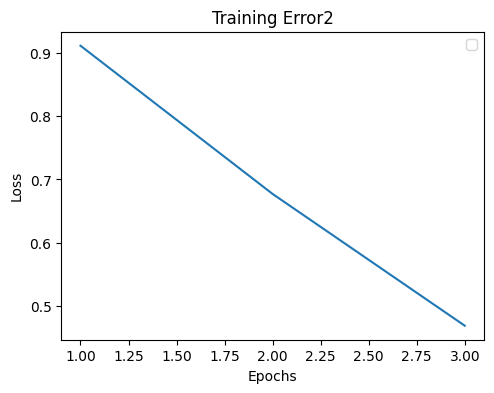

In [ ]:
import matplotlib.pyplot as plt

def plot_data(num_epochs, data, label):
    epochs_range = range(1, num_epochs + 1)
    plt.figure(figsize=(12, 4))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, data)
    plt.title(label)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def validate_model(net, val_loader, criterion, device):
    net.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = torch.tensor(inputs.numpy(), device=device).float()
            labels = torch.tensor(labels.numpy(), device=device).long()
            labels = torch.abs(labels)

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            if i == 5:
              break

    val_accuracy = correct_predictions / total_predictions
    val_error = 1 - val_accuracy
    return val_error


def train_net(net, data_loader, num_epochs):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.0001)
    plot_error = []

    for epoch in range(num_epochs):
        print('Epoch:', epoch)
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for i, (inputs, labels) in enumerate(data_loader):
            inputs = torch.tensor(inputs.numpy(), device=device).float()
            labels = torch.tensor(labels.numpy(), device=device).long()
            labels = torch.abs(labels)

            optimizer.zero_grad()
            outputs = net(inputs)
            print(outputs.shape)
            print(labels.shape)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Get the predictions from the maximum value
            _, predicted = torch.max(outputs, 1)

            # Total number of labels
            total_predictions += labels.size(0)

            # Total correct predictions
            correct_predictions += (predicted == labels).sum().item()

            # Calculate accuracy
            accuracy = correct_predictions / total_predictions

            error = 1 - accuracy  # Error is the complement of accuracy

            print(f"Batch {i} - Loss: {loss.item():.4f} Accuracy: {accuracy * 100:.2f}% Error: {error * 100:.2f}%")

            if i == 5:
                break

        # val_loss, val_error = validate_model(net, val_loader, criterion, device)
        # print(f"Validation Loss: {val_loss:.4f} Validation Error: {val_error * 100:.2f}%")

        plot_error.append(error)  # Average loss for the epoch

    print('Finished Training')

    # Plot the training error
    plot_data(num_epochs, plot_error, 'Training Error2')

train_net(model, train_loader, 3)


In [ ]:
def qualitative_results(net, data_loader, num_epochs):
    correct_per_label = {}
    number_of_labels = {}
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)

    for epoch in range(num_epochs):
        print('Epoch:', epoch)
        for i, (inputs, labels) in enumerate(data_loader):
            inputs = torch.tensor(inputs.numpy(), device=device).float()
            labels = torch.tensor(labels.numpy(), device=device).long()
            labels = torch.abs(labels)

            outputs = net(inputs)
            # Get the predictions from the maximum value
            _, predicted = torch.max(outputs, 1)

            print(outputs.shape)
            print(labels.shape)
            # print(outputs)
            # print(labels)

            for j in labels:
              if j.item() not in number_of_labels:
                number_of_labels[j.item()] = 1
              else:
                number_of_labels[j.item()] += 1


            for label, prediction in zip(labels, predicted):
                if prediction == label:
                    correct_per_label[label.item()] = correct_per_label.get(label.item(), 0) + 1

            if i == 20:
                break

    print('Finished Training')
    print(correct_per_label)
    print(number_of_labels)

    for i in number_of_labels:
      if i not in correct_per_label:
        correct_per_label[i] = 0

    for i in correct_per_label:
      print("Label", i, "Accuracy:", correct_per_label[i]/float(number_of_labels[i]))

qualitative_results(model, train_loader, 1)

Epoch: 0


<ipython-input-6-fd3c672c9a80>:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc1(x))


torch.Size([64, 88])
torch.Size([64])
torch.Size([64, 88])
torch.Size([64])
torch.Size([64, 88])
torch.Size([64])
torch.Size([64, 88])
torch.Size([64])
torch.Size([64, 88])
torch.Size([64])
torch.Size([64, 88])
torch.Size([64])
torch.Size([64, 88])
torch.Size([64])
torch.Size([64, 88])
torch.Size([64])
torch.Size([64, 88])
torch.Size([64])
torch.Size([64, 88])
torch.Size([64])
torch.Size([64, 88])
torch.Size([64])
torch.Size([64, 88])
torch.Size([64])
torch.Size([64, 88])
torch.Size([64])
torch.Size([64, 88])
torch.Size([64])
torch.Size([64, 88])
torch.Size([64])
torch.Size([64, 88])
torch.Size([64])
torch.Size([64, 88])
torch.Size([64])
torch.Size([64, 88])
torch.Size([64])
torch.Size([64, 88])
torch.Size([64])
torch.Size([64, 88])
torch.Size([64])
torch.Size([64, 88])
torch.Size([64])
Finished Training
{10: 11, 60: 12, 33: 22, 48: 6, 21: 16, 13: 9, 0: 10, 6: 6, 49: 17, 52: 14, 56: 15, 17: 19, 40: 17, 20: 10, 44: 5, 22: 17, 67: 24, 8: 4, 16: 20, 14: 15, 65: 5, 30: 18, 28: 12, 47: 15, 